# Trend plots for the absoprtion coefficient, ATP for various seasons

In this Jupyter Notebook we plot the following figures:

- ***Figure 2***: Subplot for the trends in the absorption coefficient 
- ***Figure 6***: Trend for all seasons for the precipitation
- ***Figure S8***: The absorption coefficient from 2016-2023
- ***Figure S13***: The trend in the Eurasian cluster, 2002 - 2023

In [1]:
import sys

sys.path.append(r'C:\Users\DominicHeslinRees\Documents\ACP_2023\scripts\Trends')
import trends_functions as fu_trends

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.gridspec as gridspec
import mannkendall as mk
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
savepath_plot = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\plots'

In [3]:
df_abs637 = fu_trends.load_df(loadpath=r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\absorption\appended',                   
                       filename='oldpsap_newpsap_maap',)
df_era5_GDAS = fu_trends.load_df(loadpath=r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\ERA5_rainfall',                   
                       filename='era5_GDAS_2002_2023')

loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\absorption\appended\oldpsap_newpsap_maap.dat
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\ERA5_rainfall\era5_GDAS_2002_2023.dat


In [4]:
df = pd.merge(df_abs637, df_era5_GDAS, left_index=True, right_index=True)

In [5]:
df = fu_trends.slice_df(df, start_datetime='2001-12-31') #'2006-05-05' fire
first_season = fu_trends.get_first_season(df)        
season_to_season_num = fu_trends.get_full_season_abb_years(start_year=2002, number_years=2024-2002, first_season=first_season)
season_num_to_season = fu_trends.reverse_dict(season_to_season_num)

In [6]:
df = fu_trends.prepare_data(df, dict_season_num_to_season=season_num_to_season)

start date inserted: 2002-03-08
Note: the slow build-up season crosses over two years as it goes from October-January, so the year corresponds to previous year
Number of unique seasons: 62
full_season_to_season_num given


In [7]:
df.head(2)

,abs637,fraction_241,tp_era5,RAINFALL,date,timestamp,ordinal,day,month,year,year_num,month_ordinal,month_num,season_abb,season_name,season_abb_year,season_ordinal
2002-03-08 14:00:00,0.238,1.0,6.328704,3.969907,2002-03-08,2002-03-08 14:00:00,1,8,3,2002,1,3,3,AHZ,Arctic Haze,AHZ_2002,1
2002-03-08 15:00:00,0.082,1.0,6.259259,3.277778,2002-03-08,2002-03-08 15:00:00,1,8,3,2002,1,3,3,AHZ,Arctic Haze,AHZ_2002,1


In [8]:
month_to_season =  { 1:'SBU',  2:'AHZ', 3:'AHZ',  
                     4:'AHZ',  5:'AHZ', 6:'SUM',  7:'SUM',  8:'SUM', 9:'SUM', 10:'SBU', 
                     11:'SBU', 12:'SBU'}                     
abb_to_name = { 'SBU':'Slow build up', 'AHZ':'Arctic Haze', 'SUM':'Summer/Clean'}
name_to_abb = {'Slow build up':'SBU','Arctic Haze': 'AHZ', 'Summer/Clean':'SUM'}

In [9]:
def thickax(ax, fontsize=12, linewidth=4):
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.5)
    plt.rc('axes', linewidth=linewidth)
    ax = plt.gca()
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    ax.tick_params(direction='out', length=12, width=4, pad=12, bottom=True, top=False, left=True, right=False)    
    
def fancy(ax, fontsize=20, spines=['top','bottom','left','right'], alpha=0.5):    
    # thickning the axes spines
    for axis in spines:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color('k')        
    # set the fontsize for all your ticks    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)        
    # properties of the ticks
    ax.tick_params(direction='out', length=8, width=2, pad=10, bottom=True, top=False, left=True, right=False, color='k')    
    # add a grid to the plot
    ax.grid(True, alpha=alpha)  
    
def sf(sf_num):
    sf = '{0:.'+str(sf_num)+'f}' #2 digits of precision and f is used to represent floating point number.
    return sf

def add_year_month_ordinal(df):   
    df['timestamp'] = pd.to_datetime(df.index)
    df['day'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year    
    df['year_num'] = df['year'] - df['year'].iloc[0]
    df['month_ordinal'] = df['year_num']*12 + df['month']
    df['year_num'] = df['year_num'] + 1
    return df
    
def create_month_season_numbers(df, full_season_to_season_num=None):
    start_year = df.index.year[0]
    end_year = df.index.year[-1]
    number_years = end_year - start_year #len(df.index.year.unique())+1        
    df.loc[:,'month_num'] = df.index.month
    df.loc[:,'year'] = df.index.year        
    df.loc[:,'season_abb'] = df.month_num.map(month_to_season).values
    df['season_name'] = df['season_abb'].map(abb_to_name)      
    df.loc[:, "season_abb_year"] = df["season_abb"].astype(str) + '_' +df.index.year.astype(str)
    #print("Note: the slow build-up season crosses over two years as it goes from October-January, so the year corresponds to previous year")
    df.loc[(df['season_abb'] == 'SBU') & (df['month_num'] == 1),  "season_abb_year"] = df.loc[(df['season_abb'] == 'SBU') & (df['month_num'] == 1),  "season_abb_year"].apply(lambda x: x[:-4]+str(int(x[-4:])-1))
    seasons = df.season_abb_year.unique()
    #print("Number of unique seasons: "+str(len(seasons)))    
    seasons_num = np.arange(1,len(seasons)+1,1)
    season_to_season_num = dict(zip(seasons, seasons_num))
    df.loc[:,'season_ordinal'] = df['season_abb_year'].map(season_to_season_num)    
    df = df.sort_index()
    return df

def convert_season_add_year_to_datetime(season_abb_year):
    year = str(season_abb_year)[-4:]
    season_abb = str(season_abb_year)[:3] 
    if season_abb == 'AHZ':
        start = year+'-02-'+'01'
        stop = year+'-05-'+'31'
    if season_abb == 'SUM':
        start = year+'-06-'+'01'
        stop = year+'-09-'+'30'
    if season_abb == 'SBU':
        start = year+'-10-'+'01'
        stop = str(int(year)+1)+'-01-'+'31'
    start = pd.to_datetime(start)
    stop = pd.to_datetime(stop)
    return start, stop

def mid_datetime_function(a, b):
    return a + (b - a)/2

def add_mid_datetime_using_dictionary(df, season_num_to_season):
    df['season_abb_year'] = df.index.map(season_num_to_season)
    df['start'] = df['season_abb_year'].apply(lambda x: convert_season_add_year_to_datetime(x)[0])
    df['stop'] = df['season_abb_year'].apply(lambda x: convert_season_add_year_to_datetime(x)[1])
    df['mid_datetime'] = df.apply(lambda x: mid_datetime_function(x.start, x.stop), axis=1)
    return df

## Man-kendall trends: 

In [10]:
def convert_to_datetime(x):
    x_datetime = datetime(pd.to_datetime(x).year, pd.to_datetime(x).month, pd.to_datetime(x).day)
    return x_datetime

def normal_mk_test(df_days, var='abs637', resolution=0.001):
    y0 = convert_to_datetime(df_days.index[0])
    multi_obs_dts = np.array([y0+timedelta(days=item) for item in range(len(df_days.index))])
    multi_obs = df_days[var].values #np.array(df_days.values)
    print(len(multi_obs_dts))
    print(len(multi_obs))
    #decimal places or accuracy => 2dp 
    out = mk.mk_temp_aggr(multi_obs_dts, multi_obs, resolution=resolution) #resolution?? 1/24 hourly/daily?? 
    print(out[0])
    return out

def get_relative_trend(out, df_days):
    return out[0]['slope']/df_days.median()*100

def get_dict_of_season_dfs(df):
    df = df.copy()
    if 'season' not in df.columns:
        df['season'] = df['season_abb_year'].apply(lambda x: str(x)[:3])
    df_AHZ = df[df['season'] == 'AHZ']
    df_SUM = df[df['season'] == 'SUM']
    df_SBU = df[df['season'] == 'SBU']
    dict_season_to_df = {'AHZ':df_AHZ, 'SUM':df_SUM, 'SBU':df_SBU}
    return dict_season_to_df

def get_seasonal_trend_output(dict_season_to_df, var='abs637', resolution=0.001, pw_method='3pw', alpha_xhomo=80):
    if var == 'tp_era5':
        resolution = 0.1 #decimal places
    
    df_AHZ, df_SUM, df_SBU = [*dict_season_to_df.values()][0], [*dict_season_to_df.values()][1], [*dict_season_to_df.values()][2]
    multi_obs = [df_AHZ[var].values, df_SUM[var].values, df_SBU[var].values]
    multi_obs_dts = [np.array([convert_to_datetime(x) for x in df_AHZ.index]),
                     np.array([convert_to_datetime(x) for x in df_SUM.index]), 
                     np.array([convert_to_datetime(x) for x in df_SBU.index])]
    # Process it
    out = mk.mk_temp_aggr(multi_obs_dts, multi_obs, resolution=resolution, pw_method=pw_method, 
                          alpha_xhomo=alpha_xhomo)

    n_season = 3
    # Print the results
    for n in range(n_season):
        print('Season {ind}:'.format(ind=n+1), out[n])
    print('Combined yearly trend:', out[n_season])
    return out

def produce_table(out):
    parameters = ['p', 'ss', 'slope', 'ucl', 'lcl']
    print(parameters)
    df_stats_table = pd.DataFrame(columns=parameters, dtype=np.float64)
    seasons = ['AHZ', 'SUM', 'SBU', 'combined'] #needs to be correct order
    for season_n, season_name in enumerate(seasons):
        print(season_name)
        for parameter in parameters:
            print(out[season_n][parameter])
            df_stats_table.loc[season_name, parameter] = out[season_n][parameter]
    return df_stats_table

def add_seasons_to_daily(df_days):
    month_to_season =  { 1:'SBU',  2:'AHZ', 3:'AHZ',  
                     4:'AHZ',  5:'AHZ', 6:'SUM',  7:'SUM',  8:'SUM', 9:'SUM', 10:'SBU', 
                     11:'SBU', 12:'SBU'}  

    df_days.loc[:,'month_num'] = df_days.index.month
    df_days.loc[:,'year'] = df_days.index.year        
    df_days.loc[:,'season'] = df_days.month_num.map(month_to_season).values
    return df_days

In [11]:
def seasonal_averages(df, var):
    df_seasons = df.groupby('season_ordinal').median()[var].to_frame() 
    season_num_to_season = dict(zip(df['season_ordinal'], df['season_abb_year'])) 
    df_seasons = add_mid_datetime_using_dictionary(df_seasons, season_num_to_season)
    df_seasons["season_abb"]=df_seasons["season_abb_year"].apply(lambda x: x[:3])
    return df_seasons

def remove_unwanted_values(df, var):
    df = df[[var]].copy()    
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(how='all')
    return df

def add_trend_season(df_seasons, var, freq=3, c='r', loc=1, alpha=0.05, 
                     xcoord_legend=0.5, ycoord_legend=.95, mscale = 2, fs_legend=10, uncertainty=False, 
                     sigfigs=3, linecolour='r', ax=None):
    ax2 = ax.twiny()
    x = df_seasons.index #intergers  
    y = df_seasons[var].values    
    
    res = stats.theilslopes(y, x, 0.90)
    Theil_slope = (res[1] + res[0] * x)
    lo_slope = (res[1] + res[2] * x)
    up_slope = (res[1] + res[3] * x)

    theil_m=res[0]
    theil_m = float(theil_m)*(freq)
    lo_m = float(res[2])*(freq)
    up_m = float(res[3])*(freq)

    #significant figures
    sfs = sf(sigfigs)           
    intecept=sfs.format(res[1])
    theil_m=sfs.format(theil_m)
    lo_m=sfs.format(lo_m)
    up_m=sfs.format(up_m) 
    
    if uncertainty == True:
        label=str('TS$_{\,\mathrm{S}}$:$\,$y$\,$=$\,$'+str(theil_m)+' ('+str(lo_m)+' to '+str(up_m)+')$\,\mathdefault{x}$ +'+str(intecept))
    if uncertainty == False:
        label=str('TS$_{\,\mathrm{}S}$:$\,$y$\,$=$\,$'+str(theil_m)+'$\,\mathdefault{x}$$\,$+$\,$'+str(intecept))
        
    ax2.plot(x, Theil_slope, ls='--', lw=1, c=linecolour,alpha=0.5,
            label=label)
    ax2.fill_between(x, up_slope, lo_slope, alpha=alpha, color=linecolour)
    
    legend = ax2.legend(numpoints = 1,loc='upper right',
              frameon=False, markerscale=mscale, ncol=1, fontsize=fs_legend)  
    legend.get_title().set_fontsize(fs_legend)
    
    ax2.set_xticklabels('')
    ax2.set_xticks([])
    return ax2

def daily_medians(df, var):
    df_daily_abs = df.resample('D').median()
    df_daily_abs = df_daily_abs.replace([np.inf, -np.inf], np.nan)
    df_daily_abs = df_daily_abs.dropna(how='all')
    df_daily_abs = df_daily_abs[[var]].copy()
    return df_daily_abs

def produce_seasonal_test_daily_ax(df_daily_abs, var, fs_legend=8, ms=5, freq=365.25, sigfigs=3, linecolour = 'red', 
               ylabel='$\sigma_{\mathrm{ap}}$', units='[Mm$^{-1}$]', fs_label = 12, 
               xcoord_legend=0, ycoord_legend=.98, mscale = 2, ymin=-0.1, ymax = 2, 
               alpha=0.2, uncertainty=False, add_calculated_trend=True, res_cal=None, ax=None):    
    
    ax2 = ax.twiny()
    
    #turn to intergers
    df_daily_abs['day'] = df_daily_abs.index
    df_daily_abs['ordinal'] = df_daily_abs['day'].apply(lambda x: x.toordinal())
    df_daily_abs['ordinal'] = df_daily_abs['ordinal'] - df_daily_abs['ordinal'][0] + 1

    date_ints = list(df_daily_abs['ordinal'].values)
    
    x = np.array([x-date_ints[0]+1 for x in date_ints])    
    y = df_daily_abs[var].values    
    
    res = stats.theilslopes(y, x, 0.90)
    Theil_slope = (res[1] + res[0] * x)
    lo_slope = (res[1] + res[2] * x)
    up_slope = (res[1] + res[3] * x)

    theil_m=res[0]
    theil_m = float(theil_m)*(freq)
    lo_m = float(res[2])*(freq)
    up_m = float(res[3])*(freq)

    #significant figures
    sfs = sf(sigfigs)           
    intecept=sfs.format(res[1])
    theil_m=sfs.format(theil_m)
    lo_m=sfs.format(lo_m)
    up_m=sfs.format(up_m) 
    
    if uncertainty == True:
        label=str('TS$_{\,\mathrm{D}}$: y = '+str(theil_m)+' ('+str(lo_m)+' to '+str(up_m)+')$\,\mathdefault{x}$ +'+str(intecept))
    if uncertainty == False:
        label=str('TS$_{\,\mathrm{D}}$:$\,$y$\,$=$\,$'+str(theil_m)+'$\,\mathdefault{x}$$\,$+$\,$'+str(intecept))
               
    ax2.plot(x, Theil_slope, ls='-', lw=2, c=linecolour, label=label)
    ax2.fill_between(x, up_slope, lo_slope, alpha=alpha, color=linecolour)
    
    if add_calculated_trend == True:
        
        slope_cal=res_cal[0]; intercept_cal=res_cal[1]; lo_slope_cal=res_cal[2]; up_slope_cal=res_cal[3]
        intercept_lo_cal=res_cal[4]; intercept_up_cal=res_cal[5]
        
        trend_cal_freq = slope_cal/freq                
        slope_cal = (intercept_cal + trend_cal_freq * x) #$\sigma_{\mathrm{ap, cal.}}$
        lo_slope_cal = (intercept_lo_cal + lo_slope_cal/freq * x) 
        up_slope_cal = (intercept_up_cal + up_slope_cal/freq * x) 
        
        relative_trend = sfs.format(100*float(trend_cal_freq*(freq))/float(df_daily_abs[var].median()))
        
        ax2.plot(x, slope_cal, ls='-', lw=2, c='b', 
                 label='3pw$_{\mathrm{trend}}$ = '+str(sfs.format(trend_cal_freq*(freq)))+' '+str(units)[:-1]+' yr$^{-1}$]'+'\nrel. 3pw$_{\mathrm{trend}}$ = '+str(relative_trend)+' [%yr$^{-1}$]')
        ax2.fill_between(x, up_slope_cal, lo_slope_cal, alpha=alpha, color='b')

    ax2.set_xticks([])
    
    legend = ax2.legend(numpoints = 1, loc='upper left', 
              frameon=False, markerscale=mscale, ncol=1, fontsize=fs_legend)  
    legend.get_title().set_fontsize(fs_legend)
    return ax

In [12]:
df.head(2)

,abs637,fraction_241,tp_era5,RAINFALL,date,timestamp,ordinal,day,month,year,year_num,month_ordinal,month_num,season_abb,season_name,season_abb_year,season_ordinal
2002-03-08 14:00:00,0.238,1.0,6.328704,3.969907,2002-03-08,2002-03-08 14:00:00,1,8,3,2002,1,3,3,AHZ,Arctic Haze,AHZ_2002,1
2002-03-08 15:00:00,0.082,1.0,6.259259,3.277778,2002-03-08,2002-03-08 15:00:00,1,8,3,2002,1,3,3,AHZ,Arctic Haze,AHZ_2002,1


In [13]:
dict_season_to_color = dict(zip(['AHZ', 'SBU', 'SUM', 'all_seasons'], ["#41b6c4", "#2c7fb8", "#253494", 'k']))
dict_season_to_ylim = dict(zip(['AHZ', 'SBU', 'SUM', 'all_seasons'], [20, 20, 20, 20]))

In [14]:
df = remove_unwanted_values(df, var='tp_era5')
df = create_month_season_numbers(df, full_season_to_season_num=season_to_season_num)
df_seasons = seasonal_averages(df, var='tp_era5')

In [15]:
def make_subplot(df, df_seasons, var, season, dict_season_to_color, fs_legend=12, fs_label=12,
                 ymax=0.8, add_calculated_trend=True, alpha_xhomo=80, sigfigs=3, ax=None):
    print("season: "+str(season))
    #seasonal
    df_seasons_ = df_seasons[df_seasons["season_abb"] == str(season)].copy()
    add_trend_season(df_seasons_, var, freq=3, c='r', xcoord_legend=0., ycoord_legend=1.02, 
                     fs_legend=fs_legend, ax=ax)
    ax.plot(df_seasons_['mid_datetime'], df_seasons_[var], 'o', ls=':', c=dict_season_to_color[season])

    #daily
    df_ = df[df['season_abb'] == str(season)].copy()
    df_daily_ = daily_medians(df_, var)
    ax.plot(df_daily_.index, df_daily_[var], 'o', c=dict_season_to_color[season], ms=1, alpha=0.4)
    
    #pw_trend 
    res_cal=None
    if add_calculated_trend == True:
        df_daily_ = add_seasons_to_daily(df_daily_)
        dict_season_to_df = get_dict_of_season_dfs(df_daily_)
        out = get_seasonal_trend_output(dict_season_to_df, var=var, alpha_xhomo=alpha_xhomo)
        df_stats_table = produce_table(out)
        slope_cal = float(df_stats_table.loc[season]['slope'])
        lo_slope_cal = float(df_stats_table.loc[season]['lcl'])
        up_slope_cal = float(df_stats_table.loc[season]['ucl'])
        
        time_med = df.iloc[int(len(df_)/2):int(len(df_)/2)+1].season_ordinal.values[0]
        intercept_cal = df_daily_[var].median() - slope_cal*time_med #c = y - mx
        
        intercept_lo_cal = df_daily_[var].median() - lo_slope_cal*time_med #c = y - mx
        intercept_up_cal = df_daily_[var].median() - up_slope_cal*time_med #c = y - mx
        
        res_cal = (slope_cal, intercept_cal, lo_slope_cal, up_slope_cal, intercept_lo_cal, intercept_up_cal)
        
    produce_seasonal_test_daily_ax(df_daily_, var, fs_legend=fs_legend, ms=5, freq=365, sigfigs=sigfigs, linecolour = 'r', 
                   ylabel='$\sigma_{\mathrm{ap}}$', units='[Mm$^{-1}$]', fs_label=fs_label, 
                   xcoord_legend=0., ycoord_legend=.8, mscale = 2, ymin=-0.1, ymax=2, 
                   add_calculated_trend=add_calculated_trend, 
                   res_cal=res_cal, ax=ax)
    ax.set_ylim(-0, ymax)
    return ax

In [16]:
def make_subplot_full(df, df_seasons, var, fs_legend=12, fs_label=15, ymax=0.8, 
                      ylabel='$\sigma_{\mathrm{ap}}$', units='[Mm$^{-1}$]', add_calculated_trend=True, 
                      alpha_xhomo=80, c='k', sigfigs=3, ax=None):
    #seasonal
    add_trend_season(df_seasons, var, freq=3, c='r', xcoord_legend=0., ycoord_legend=.98, 
                     fs_legend=fs_legend, ax=ax)
    ax.plot(df_seasons['mid_datetime'], df_seasons[var], 'o', ls=':', c=c)

    #daily
    df_daily = daily_medians(df, var)
    ax.plot(df_daily.index, df_daily[var], 'o', c=c, ms=1, alpha=0.4)

    #pw_trend 
    res_cal=None
    if add_calculated_trend == True:
        df_daily = add_seasons_to_daily(df_daily)
        dict_season_to_df = get_dict_of_season_dfs(df_daily)
        out = get_seasonal_trend_output(dict_season_to_df, var=var, alpha_xhomo=alpha_xhomo)
        df_stats_table = produce_table(out)

        slope_cal = float(df_stats_table.loc['combined']['slope'])
        lo_slope_cal = float(df_stats_table.loc['combined']['lcl'])
        up_slope_cal = float(df_stats_table.loc['combined']['ucl'])
        
        time_med = df.iloc[int(len(df)/2):int(len(df)/2)+1].season_ordinal.values[0]
        intercept_cal = df_daily[var].median() - slope_cal*time_med #c = y - mx
        
        intercept_lo_cal = df_daily[var].median() - lo_slope_cal*time_med #c = y - mx
        intercept_up_cal = df_daily[var].median() - up_slope_cal*time_med #c = y - mx
        
        res_cal = (slope_cal, intercept_cal, lo_slope_cal, up_slope_cal, intercept_lo_cal, intercept_up_cal)
        
    produce_seasonal_test_daily_ax(df_daily, var, fs_legend=fs_legend, ms=5, freq=365, sigfigs=sigfigs, linecolour = 'r', 
                   ylabel=ylabel, units=units, fs_label=fs_label, xcoord_legend=0., ycoord_legend=.89, 
                   mscale = 2, ymin=-0.1, ymax=2, add_calculated_trend=add_calculated_trend, 
                                   res_cal=res_cal, ax=ax)
    ax.set_ylim(-0, ymax)
    return ax

In [17]:
def season_plot(df, df_seasons, var, season, ymax2,  dict_season_to_color=dict_season_to_color,
               dict_season_to_ylim=dict_season_to_ylim, fs_ticks=20, fs_label=30, ylabel='', units=''):
    
    fig = plt.figure(figsize=(8, 5))
    ymax = dict_season_to_ylim[season]

    gs = gridspec.GridSpec(ncols=1, nrows=3, hspace = 0.2, wspace = 0.2, top = 1,
                           bottom = 0, left = 0, right = 1)

    ax = fig.add_subplot(gs[0:1])
    df_ = df[df['season_abb'] == str(season)].copy()
    ax.plot(df_.index, df_[var], 'o', c=dict_season_to_color[season], ms=1, alpha=0.4)
    ax.set_ylim(ymax, ymax2)
    fancy(ax, fontsize=fs_ticks, spines=['top','bottom','left','right'], alpha=0.5) 
    ax.set_xticklabels([])

    ax = fig.add_subplot(gs[1:3])
    make_subplot(df, df_seasons, var=var, season=season, dict_season_to_color=dict_season_to_color, 
                 ax=ax)
    fancy(ax, fontsize=fs_ticks, spines=['top','bottom','left','right'], alpha=0.5) 
    ax.set_ylim(0, ymax)

    fig.text(-0.15, 0.5, ylabel+' '+units, ha='center', va='center', rotation='vertical', fontsize=fs_label)

    plt.show()
    return fig

In [18]:
def subplots(df, df_seasons, var, dict_season_to_color, dict_season_to_ylim, fs_label=15, fs_legend = 10, fs_tick=15, 
             fs_letter = 20, ymax2=30, name='trend_plot', alpha_xhomo=80, c='k', ylabel='$\sigma_{\mathrm{ap}}$',
             units='[Mm$^{-1}$]'):
    fig = plt.figure(figsize=(15, 8))

    gs = gridspec.GridSpec(ncols=3, nrows=8, hspace = 0.2, wspace = 0.2, top = 1,
                               bottom = 0, left = 0, right = 1)
    #AHZ
    season='AHZ'
    ax = fig.add_subplot(gs[0:1])

    df_ = df[df['season_abb'] == str(season)].copy()
    ax.plot(df_.index, df_[var], 'o', c=dict_season_to_color[season], ms=1, alpha=0.4)
    ax.set_ylim(dict_season_to_ylim[season], ymax2)
    ax.text(.01, 1.6, 'a) Arctic Haze', ha='left', va='top', transform=ax.transAxes, fontsize=fs_letter)

    fancy(ax, fontsize=fs_tick, spines=['top','bottom','left','right'], alpha=0.5) 
    ax.set_xticklabels([''])

    ax = fig.add_subplot(gs[1:3, 0:1])
    make_subplot(df, df_seasons, var, season, dict_season_to_color, fs_legend=fs_legend, fs_label=fs_label, ax=ax)
    ax.set_ylim(0, dict_season_to_ylim[season])

    ax.yaxis.set_major_locator(plt.MaxNLocator(3))

    fancy(ax, fontsize=fs_tick, spines=['top','bottom','left','right'], alpha=0.5)    

    #SBU
    season='SBU'
    ax = fig.add_subplot(gs[1:2])

    df_ = df[df['season_abb'] == str(season)].copy()
    ax.plot(df_.index, df_[var], 'o', c=dict_season_to_color[season], ms=1, alpha=0.4)
    ax.set_ylim(dict_season_to_ylim[season], ymax2)
    thickax(ax, fontsize=fs_label, linewidth=1)
    ax.text(.01, 1.6, 'b) Summer', ha='left', va='top', transform=ax.transAxes, fontsize=fs_letter)
    fancy(ax, fontsize=fs_label, spines=['top','bottom','left','right'], alpha=0.5) 
    ax.set_xticklabels([''])

    ax = fig.add_subplot(gs[1:3, 1:2])

    make_subplot(df, df_seasons, var, season, dict_season_to_color, fs_legend=fs_legend, fs_label=fs_label, ax=ax)
    ax.set_ylim(0, dict_season_to_ylim[season])
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))

    fancy(ax, fontsize=fs_tick, spines=['top','bottom','left','right'], alpha=0.5)  

    #SUM
    season='SUM'

    ax = fig.add_subplot(gs[2:3])

    df_ = df[df['season_abb'] == str(season)].copy()
    ax.plot(df_.index, df_[var], 'o', c=dict_season_to_color[season], ms=1, alpha=0.4)
    ax.set_ylim(dict_season_to_ylim[season], ymax2)
    thickax(ax, fontsize=fs_label, linewidth=1)
    ax.text(.01, 1.6, 'c) Slow build-up season', ha='left', va='top', transform=ax.transAxes, fontsize=fs_letter)
    fancy(ax, fontsize=fs_label, spines=['top','bottom','left','right'], alpha=0.5) 
    ax.set_xticklabels([''])

    ax = fig.add_subplot(gs[1:3, 2:3])

    make_subplot(df, df_seasons, var, season, dict_season_to_color, fs_legend=fs_legend, fs_label=fs_label, ax=ax)
    ax.set_ylim(0, dict_season_to_ylim[season])
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))

    fancy(ax, fontsize=fs_tick, spines=['top','bottom','left','right'], alpha=0.5)  

    #FULL
    season = 'all_seasons'
    ax = fig.add_subplot(gs[4:5, 0:3])

    ax.plot(df.index, df[var], 'o', c='k', ms=1, alpha=0.4)
    ax.set_ylim(dict_season_to_ylim[season], ymax2)
    thickax(ax, fontsize=fs_label, linewidth=1)
    ax.text(.01, 1.6, 'd) All seasons', ha='left', va='top', transform=ax.transAxes, fontsize=fs_letter)
    fancy(ax, fontsize=fs_label, spines=['top','bottom','left','right'], alpha=0.5) 
    ax.set_xticklabels([''])

    ax = fig.add_subplot(gs[5:8, 0:3])
    ymax = dict_season_to_ylim[season]
    make_subplot_full(df, df_seasons, var, fs_legend=fs_legend*2, fs_label=fs_label, 
                      ymax=ymax, ylabel=ylabel, units=units, alpha_xhomo=alpha_xhomo, c=c, ax=ax)
    ax.set_ylim(0, dict_season_to_ylim[season])
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    fancy(ax, fontsize=fs_tick, spines=['top','bottom','left','right'], alpha=0.5)  

    fig.text(-0.08, 0.5, ylabel+' '+units, ha='center', va='center', rotation='vertical', fontsize=30)

    plt.show()

    fu_trends.save_plot(fig, name, formate='.png')
    return fig

In [19]:
def full_plot(df, df_seasons, var, ymax2, season='all_seasons', ylabel='', 
              units='', dict_season_to_color=dict_season_to_color,
              dict_season_to_ylim=dict_season_to_ylim, fs_ticks=20, fs_legend=20, fs_label=30,
              alpha_xhomo=80, c='k'):
    
    fig = plt.figure(figsize=(12, 6))
    ymax = dict_season_to_ylim[season]

    gs = gridspec.GridSpec(ncols=1, nrows=3, hspace = 0.2, wspace = 0.2, top = 1,
                           bottom = 0, left = 0, right = 1)

    ax = fig.add_subplot(gs[0:1])
    df_AHZ = df[df['season_abb'] == 'AHZ'].copy()
    ax.plot(df_AHZ.index, df_AHZ[var], 'o', c=dict_season_to_color['all_seasons'], ms=1)
    df_SBU = df[df['season_abb'] == 'SBU'].copy()
    ax.plot(df_SBU.index, df_SBU[var], 'o', c=dict_season_to_color['all_seasons'], ms=1)
    df_SUM = df[df['season_abb'] == 'SUM'].copy()
    ax.plot(df_SUM.index, df_SUM[var], 'o', c=dict_season_to_color['all_seasons'], ms=1)
    
    ax.set_ylim(ymax, ymax2)
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    fancy(ax, fontsize=fs_ticks, spines=['top','bottom','left','right'], alpha=0.5) 
    ax.set_xticklabels([''])
    
    #GCVI
    #ax.axvspan(pd.to_datetime('2015-11-01'), pd.to_datetime('2019-11-01'), alpha=0.2, color='k')

    ax = fig.add_subplot(gs[1:3])
    make_subplot_full(df, df_seasons, var, fs_legend=fs_legend, fs_label=fs_label, 
                      ymax=ymax, ylabel=ylabel, units=units, alpha_xhomo=alpha_xhomo, c=c, ax=ax)
    fancy(ax, fontsize=fs_ticks, spines=['top','bottom','left','right'], alpha=0.5) 
    ax.set_ylim(0, ymax)
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))

    #GCVI
    #ax.axvspan(pd.to_datetime('2015-11-01'), pd.to_datetime('2019-11-01'), alpha=0.2, color='k')
    
    fig.text(-0.1, 0.5, ylabel+' '+units, ha='center', va='center', rotation='vertical', fontsize=fs_label)

    plt.show()
    return fig

# Accumulated back Trajectory Precipitation

## Figure 6: 

<ipython-input-19-bdeab0dc470e>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])


Season 1: {'p': 0.14495826920907606, 'ss': -1, 'slope': 0.020274725746109577, 'ucl': 0.07691039364713524, 'lcl': -0.03636564892206999}
Season 2: {'p': 0.04942967722255687, 'ss': 95, 'slope': 0.06773404724768221, 'ucl': 0.1452758068830885, 'lcl': -0.008934413578959003}
Season 3: {'p': 0.28478041953128796, 'ss': -1, 'slope': 0.02827057256738518, 'ucl': 0.11378677950490364, 'lcl': -0.05761106442535487}
Combined yearly trend: {'p': 0.008816159703009419, 'ss': 95, 'slope': 0.02827057256738518, 'ucl': 0.11378677950490364, 'lcl': -0.03636564892206999}
['p', 'ss', 'slope', 'ucl', 'lcl']
AHZ
0.14495826920907606
-1
0.020274725746109577
0.07691039364713524
-0.03636564892206999
SUM
0.04942967722255687
95
0.06773404724768221
0.1452758068830885
-0.008934413578959003
SBU
0.28478041953128796
-1
0.02827057256738518
0.11378677950490364
-0.05761106442535487
combined
0.008816159703009419
95
0.02827057256738518
0.11378677950490364
-0.03636564892206999


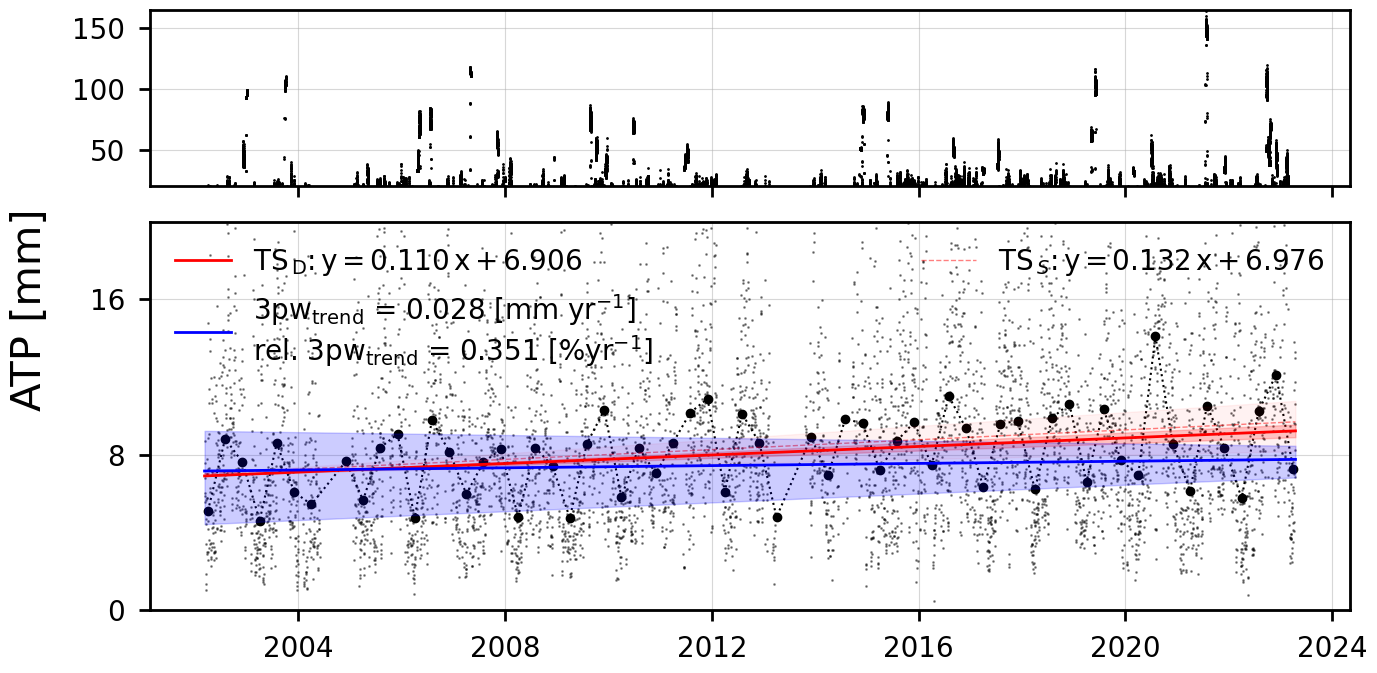

saved as: C:\Users\DominicHeslinRees\Documents\ACP_2023\plots\\Figure6.png


In [20]:
fig = full_plot(df, df_seasons, var='tp_era5', ymax2=165, ylabel='ATP', units='[mm]', alpha_xhomo=80)
fu_trends.save_plot(fig, savepath_plot, name='Figure6', formate='.png')

# Absoprtion: 

In [21]:
df_abs637 = fu_trends.load_df(loadpath=r'C:\Users\DominicHeslinRees\Documents\Analysis\absorption\appended',                   
                       filename='oldpsap_newpsap_maap',)
df_era5_GDAS = fu_trends.load_df(loadpath=r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\ERA5_rainfall',                   
                       filename='era5_GDAS_2002_2023',)
df = pd.merge(df_abs637, df_era5_GDAS, left_index=True, right_index=True)

df = fu_trends.slice_df(df, start_datetime='2001-12-31') #'2006-05-05' fire
first_season = fu_trends.get_first_season(df)        
season_to_season_num = fu_trends.get_full_season_abb_years(start_year=2002, number_years=2024-2002, first_season=first_season)
season_num_to_season = fu_trends.reverse_dict(season_to_season_num)

df = fu_trends.prepare_data(df, season_num_to_season)

df = remove_unwanted_values(df, var='abs637')
df = create_month_season_numbers(df, full_season_to_season_num=season_to_season_num)
df_seasons = seasonal_averages(df, var='abs637')

loading: C:\Users\DominicHeslinRees\Documents\Analysis\absorption\appended\oldpsap_newpsap_maap.dat
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\ERA5_rainfall\era5_GDAS_2002_2023.dat
start date inserted: 2002-03-08
Note: the slow build-up season crosses over two years as it goes from October-January, so the year corresponds to previous year
Number of unique seasons: 62
full_season_to_season_num given


## Figure 2: 

<ipython-input-18-1bf44913646e>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])


season: AHZ
Season 1: {'p': 0.008334629661753912, 'ss': 95, 'slope': -0.0014798030835933163, 'ucl': 0.00012194583096899389, 'lcl': -0.0031317745246651507}
Season 2: {'p': nan, 'ss': nan, 'slope': nan, 'ucl': nan, 'lcl': nan}
Season 3: {'p': nan, 'ss': nan, 'slope': nan, 'ucl': nan, 'lcl': nan}
Combined yearly trend: {'p': 0.008334629661753912, 'ss': 95, 'slope': -0.0014798030835933163, 'ucl': 0.00012194583096899389, 'lcl': -0.0031317745246651507}
['p', 'ss', 'slope', 'ucl', 'lcl']
AHZ
0.008334629661753912
95
-0.0014798030835933163
0.00012194583096899389
-0.0031317745246651507
SUM
nan
nan
nan
nan
nan
SBU
nan
nan
nan
nan
nan
combined
0.008334629661753912
95
-0.0014798030835933163
0.00012194583096899389
-0.0031317745246651507


<ipython-input-18-1bf44913646e>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])


season: SBU
Season 1: {'p': nan, 'ss': nan, 'slope': nan, 'ucl': nan, 'lcl': nan}
Season 2: {'p': nan, 'ss': nan, 'slope': nan, 'ucl': nan, 'lcl': nan}
Season 3: {'p': 0.0015203121185305424, 'ss': 95, 'slope': -0.0008339735012919875, 'ucl': -0.0002471919745340815, 'lcl': -0.0014349090465003648}
Combined yearly trend: {'p': 0.0015203121185305424, 'ss': 95, 'slope': -0.0008339735012919875, 'ucl': -0.0002471919745340815, 'lcl': -0.0014349090465003648}
['p', 'ss', 'slope', 'ucl', 'lcl']
AHZ
nan
nan
nan
nan
nan
SUM
nan
nan
nan
nan
nan
SBU
0.0015203121185305424
95
-0.0008339735012919875
-0.0002471919745340815
-0.0014349090465003648
combined
0.0015203121185305424
95
-0.0008339735012919875
-0.0002471919745340815
-0.0014349090465003648


<ipython-input-18-1bf44913646e>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])


season: SUM
Season 1: {'p': nan, 'ss': nan, 'slope': nan, 'ucl': nan, 'lcl': nan}
Season 2: {'p': 2.0970367711203863e-06, 'ss': 95, 'slope': -0.0006186342761924355, 'ucl': -0.00037231990094556845, 'lcl': -0.0008704970894819399}
Season 3: {'p': nan, 'ss': nan, 'slope': nan, 'ucl': nan, 'lcl': nan}
Combined yearly trend: {'p': 2.0970367711203863e-06, 'ss': 95, 'slope': -0.0006186342761924355, 'ucl': -0.00037231990094556845, 'lcl': -0.0008704970894819399}
['p', 'ss', 'slope', 'ucl', 'lcl']
AHZ
nan
nan
nan
nan
nan
SUM
2.0970367711203863e-06
95
-0.0006186342761924355
-0.00037231990094556845
-0.0008704970894819399
SBU
nan
nan
nan
nan
nan
combined
2.0970367711203863e-06
95
-0.0006186342761924355
-0.00037231990094556845
-0.0008704970894819399


<ipython-input-18-1bf44913646e>:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])


Season 1: {'p': 0.008316960340718937, 'ss': 95, 'slope': -0.0022257869997864524, 'ucl': -0.0006008931386365376, 'lcl': -0.003892467562326214}
Season 2: {'p': 0.0007158862634271124, 'ss': 95, 'slope': -0.0004470774442547459, 'ucl': -2.943228905487697e-05, 'lcl': -0.0008711500381413487}
Season 3: {'p': 0.02217335570024126, 'ss': 95, 'slope': -0.0006366671673837612, 'ucl': 0.0001409413238209033, 'lcl': -0.0014352944859701833}
Combined yearly trend: {'p': 1.4391002447489143e-06, 'ss': 95, 'slope': -0.0006366671673837612, 'ucl': -2.943228905487697e-05, 'lcl': -0.0014352944859701833}
['p', 'ss', 'slope', 'ucl', 'lcl']
AHZ
0.008316960340718937
95
-0.0022257869997864524
-0.0006008931386365376
-0.003892467562326214
SUM
0.0007158862634271124
95
-0.0004470774442547459
-2.943228905487697e-05
-0.0008711500381413487
SBU
0.02217335570024126
95
-0.0006366671673837612
0.0001409413238209033
-0.0014352944859701833
combined
1.4391002447489143e-06
95
-0.0006366671673837612
-2.943228905487697e-05
-0.0014352

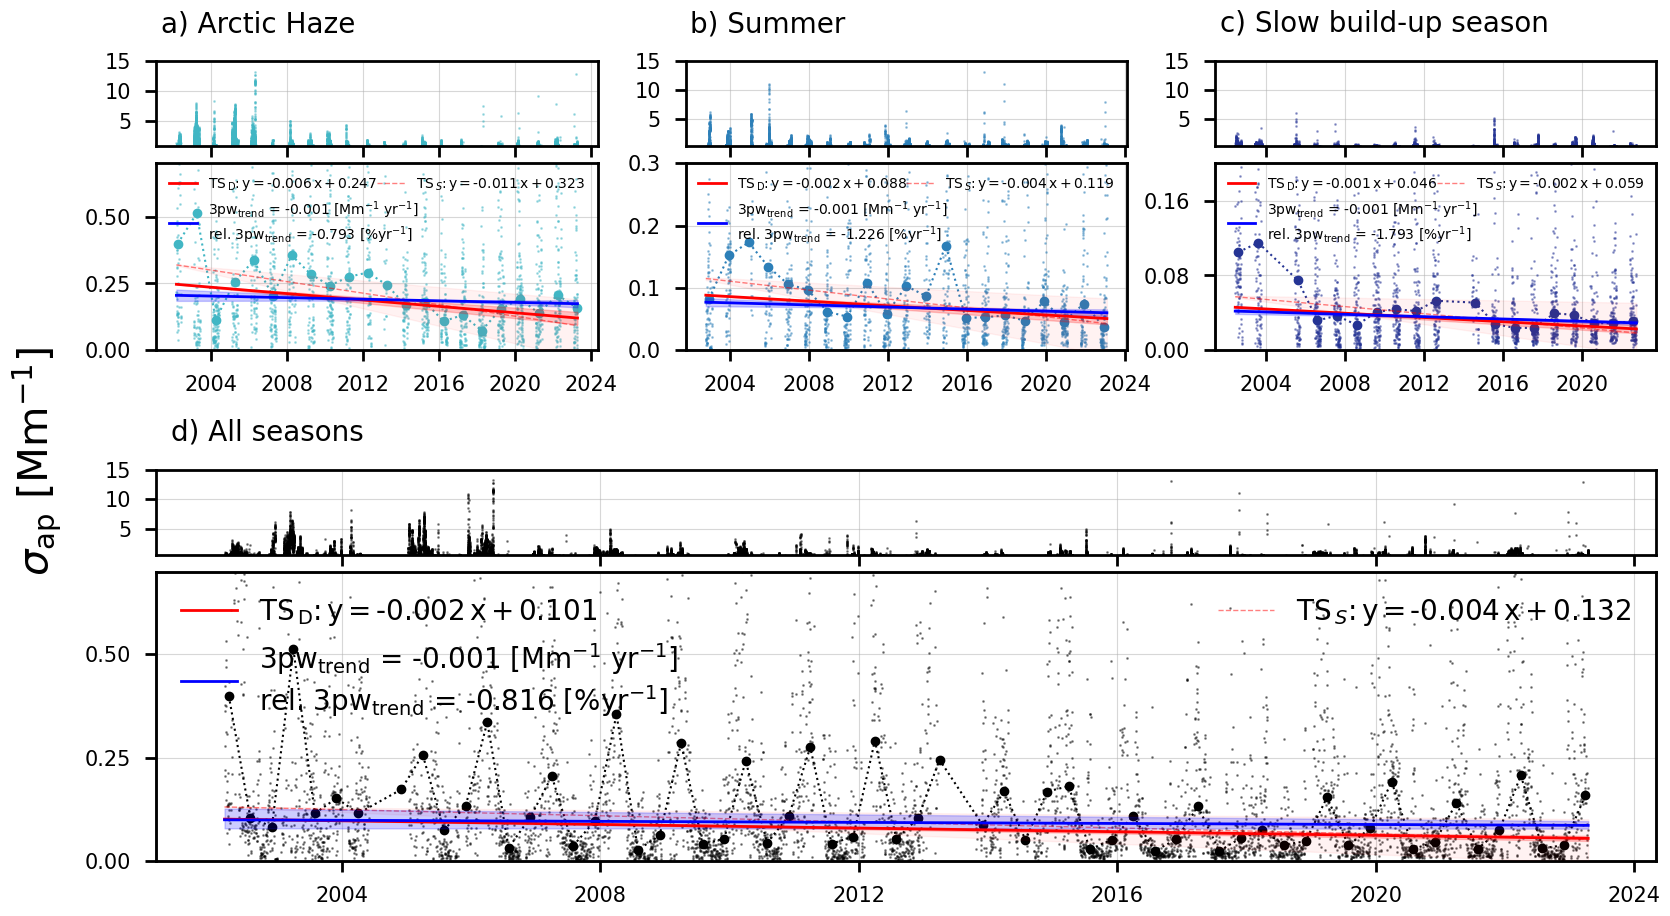

saved as: abs_trend_plot\\default_name.png
saved as: C:\Users\DominicHeslinRees\Documents\ACP_2023\plots\\Figure2.png


In [22]:
dict_season_to_ylim = dict(zip(['AHZ', 'SBU', 'SUM', 'all_seasons'], [0.7, 0.3, 0.2, 0.7]))
fig = subplots(df, df_seasons, var='abs637', ymax2=15, dict_season_to_color=dict_season_to_color, 
               dict_season_to_ylim=dict_season_to_ylim, name='abs_trend_plot', alpha_xhomo=83) 
fu_trends.save_plot(fig, savepath_plot, name='Figure2', formate='.png')

<ipython-input-19-bdeab0dc470e>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])


Season 1: {'p': 0.008316960340718937, 'ss': 95, 'slope': -0.0022257869997864524, 'ucl': -0.0006008931386365376, 'lcl': -0.003892467562326214}
Season 2: {'p': 0.0007158862634271124, 'ss': 95, 'slope': -0.0004470774442547459, 'ucl': -2.943228905487697e-05, 'lcl': -0.0008711500381413487}
Season 3: {'p': 0.02217335570024126, 'ss': 95, 'slope': -0.0006366671673837612, 'ucl': 0.0001409413238209033, 'lcl': -0.0014352944859701833}
Combined yearly trend: {'p': 1.4391002447489143e-06, 'ss': 95, 'slope': -0.0006366671673837612, 'ucl': -2.943228905487697e-05, 'lcl': -0.0014352944859701833}
['p', 'ss', 'slope', 'ucl', 'lcl']
AHZ
0.008316960340718937
95
-0.0022257869997864524
-0.0006008931386365376
-0.003892467562326214
SUM
0.0007158862634271124
95
-0.0004470774442547459
-2.943228905487697e-05
-0.0008711500381413487
SBU
0.02217335570024126
95
-0.0006366671673837612
0.0001409413238209033
-0.0014352944859701833
combined
1.4391002447489143e-06
95
-0.0006366671673837612
-2.943228905487697e-05
-0.0014352

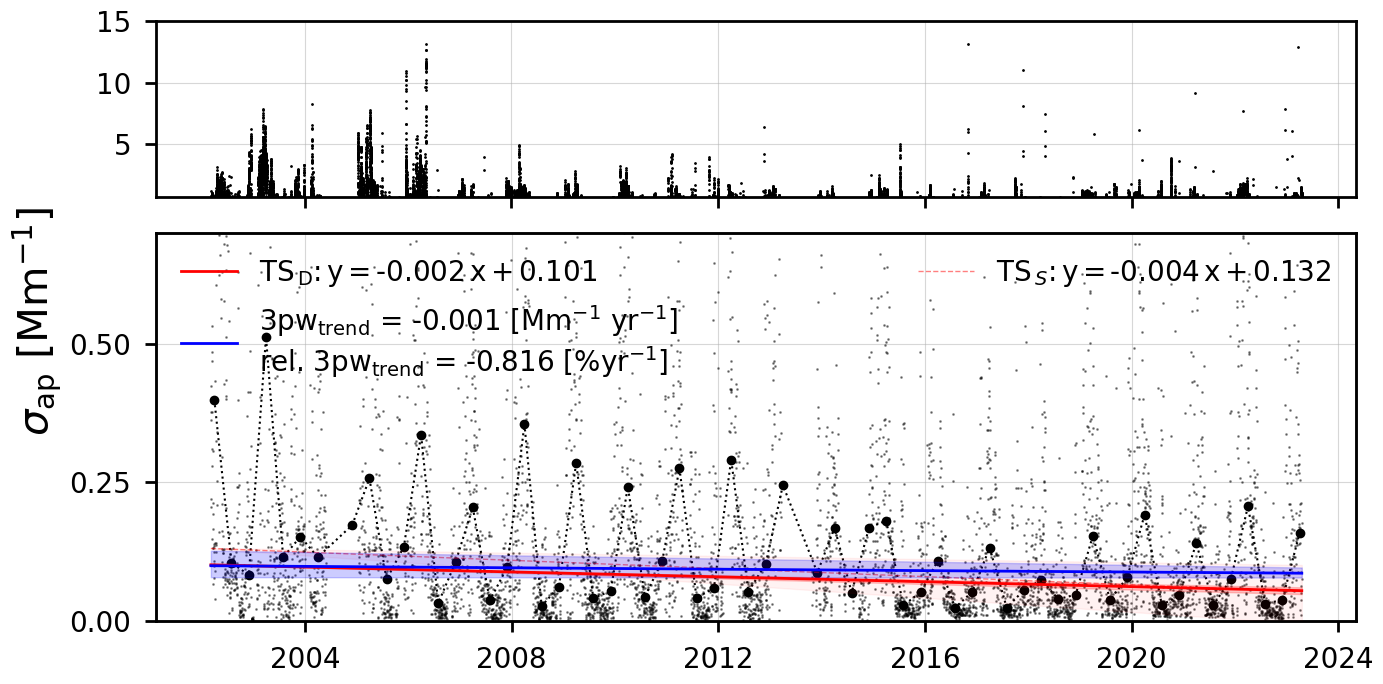

In [23]:
fig = full_plot(df, df_seasons, var='abs637', ymax2=15, dict_season_to_color=dict_season_to_color, 
               dict_season_to_ylim=dict_season_to_ylim, alpha_xhomo=83, ylabel='$\sigma_{\mathrm{ap}}$', units='[Mm$^{-1}$]')

## From 2016/2017: 

### Figure S8

In [24]:
df = fu_trends.slice_df(df, start_datetime='2015-12-31') #'2006-05-05' fire
first_season = fu_trends.get_first_season(df)   

start_year = df.index.year[0]
print(start_year)
print(len(df.index.year.unique()))

season_to_season_num = fu_trends.get_full_season_abb_years(start_year=start_year, number_years=2024-start_year, first_season=first_season)
season_num_to_season = fu_trends.reverse_dict(season_to_season_num)

df = fu_trends.prepare_data(df, season_num_to_season)

df = remove_unwanted_values(df, var='abs637')
df = create_month_season_numbers(df, full_season_to_season_num=season_to_season_num)
df_seasons = seasonal_averages(df, var='abs637')

2016
8
SBU
2016
start date inserted: 2016-01-11
Note: the slow build-up season crosses over two years as it goes from October-January, so the year corresponds to previous year
Number of unique seasons: 23
full_season_to_season_num given


<ipython-input-19-bdeab0dc470e>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])


Season 1: {'p': 0.037631458500343884, 'ss': 95, 'slope': 0.00508545982010975, 'ucl': 0.009698068298070784, 'lcl': 0.0006193205234937919}
Season 2: {'p': 0.7414221971290844, 'ss': -1, 'slope': -0.00010473949432143912, 'ucl': 0.0010129650996546966, 'lcl': -0.0011800459868504694}
Season 3: {'p': 0.6125411053488015, 'ss': -1, 'slope': 0.0004388032794873769, 'ucl': 0.0025225543562995057, 'lcl': -0.0016110367386573334}
Combined yearly trend: {'p': 0.0846739483493586, 'ss': -1, 'slope': 0.0004388032794873769, 'ucl': 0.0025225543562995057, 'lcl': -0.0011800459868504694}
['p', 'ss', 'slope', 'ucl', 'lcl']
AHZ
0.037631458500343884
95
0.00508545982010975
0.009698068298070784
0.0006193205234937919
SUM
0.7414221971290844
-1
-0.00010473949432143912
0.0010129650996546966
-0.0011800459868504694
SBU
0.6125411053488015
-1
0.0004388032794873769
0.0025225543562995057
-0.0016110367386573334
combined
0.0846739483493586
-1
0.0004388032794873769
0.0025225543562995057
-0.0011800459868504694


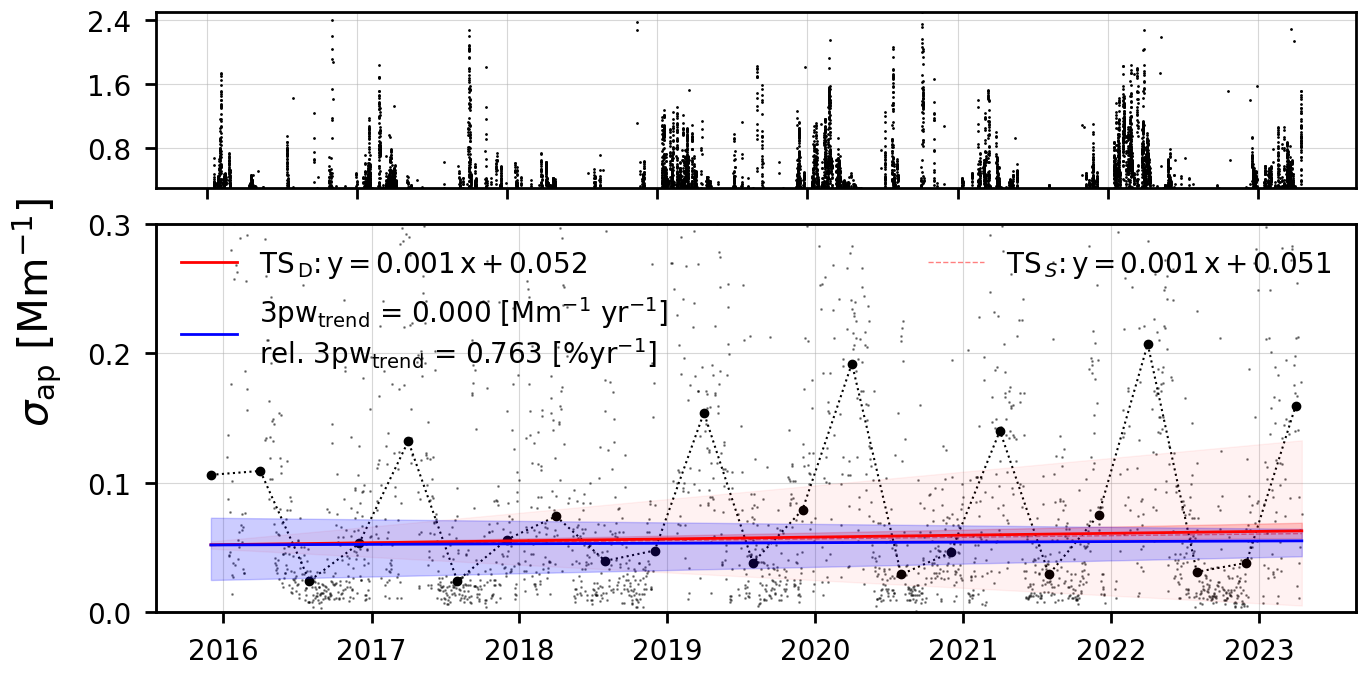

In [25]:
fig = full_plot(df, df_seasons, var='abs637', season='AHZ', ymax2=2.5, 
                  dict_season_to_color = dict(zip(['AHZ', 'SBU', 'SUM', 'all_seasons'], ['k', 'k', 'k', 'k'])),
                  dict_season_to_ylim={'AHZ': 0.3, 'SBU': 0.3, 'SUM': 0.2, 'all_seasons': 0.7}, 
                  ylabel='$\sigma_{\mathrm{ap}}$', units='[Mm$^{-1}$]', alpha_xhomo=25)

season: AHZ
Season 1: {'p': 0.01103400932055898, 'ss': 95, 'slope': 0.0043779165424650225, 'ucl': 0.008482244617078898, 'lcl': 0.0003732504613318118}
Season 2: {'p': nan, 'ss': nan, 'slope': nan, 'ucl': nan, 'lcl': nan}
Season 3: {'p': nan, 'ss': nan, 'slope': nan, 'ucl': nan, 'lcl': nan}
Combined yearly trend: {'p': 0.01103400932055898, 'ss': 95, 'slope': 0.0043779165424650225, 'ucl': 0.008482244617078898, 'lcl': 0.0003732504613318118}
['p', 'ss', 'slope', 'ucl', 'lcl']
AHZ
0.01103400932055898
95
0.0043779165424650225
0.008482244617078898
0.0003732504613318118
SUM
nan
nan
nan
nan
nan
SBU
nan
nan
nan
nan
nan
combined
0.01103400932055898
95
0.0043779165424650225
0.008482244617078898
0.0003732504613318118


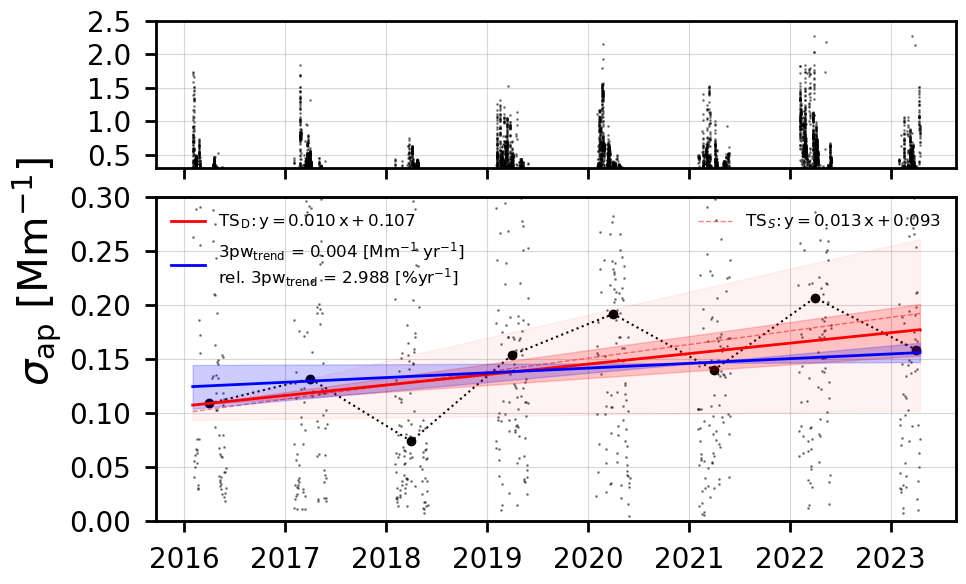

saved as: C:\Users\DominicHeslinRees\Documents\ACP_2023\plots\\FigureS8.png


In [26]:
fig = season_plot(df, df_seasons, var='abs637', season='AHZ', ymax2=2.5, 
                  dict_season_to_color = dict(zip(['AHZ', 'SBU', 'SUM', 'all_seasons'], ['k', 'k', 'k', 'k'])),
                  dict_season_to_ylim={'AHZ': 0.3, 'SBU': 0.3, 'SUM': 0.2, 'all_seasons': 0.7}, 
                  ylabel='$\sigma_{\mathrm{ap}}$', units='[Mm$^{-1}$]')
fu_trends.save_plot(fig, savepath_plot, name='FigureS8', formate='.png')

# Cluster trends: 

In [27]:
df_max_count_abs637 = pd.read_csv(r'C:\Users\DominicHeslinRees\Documents\Analysis\Clustering\timeseries\cluster_timeseries.dat',
                                 index_col=0, parse_dates=True)

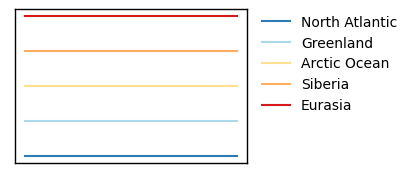

In [28]:
colors=['#a6611a','#dfc27d','#f5f5f5','#80cdc1','#018571']
colors = ['#d7191c','#fdae61','#ffffbf','#abd9e9','#2c7bb6']
colors = sns.color_palette("colorblind")[:5]

#red #orange #yellow #light blue #dark blue
colors = ['#2c7bb6', '#abd9e9','#fee090','#fdae61','#d7191c']
clusters = np.arange(1, 6, 1)
names = ['North Atlantic', 'Greenland', 'Arctic Ocean', 'Siberia', 'Eurasia']
dict_titles = dict(zip(names, clusters))

fig, ax = plt.subplots(figsize=(3,2))
for i, color in enumerate(colors):
    plt.plot([0, 1], [i, i], color=color, label=names[i])
plt.legend(frameon=False, bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.yticks([])
plt.xticks([])

plt.show()

dict_cluster_to_colors = dict(zip(np.arange(1,6,1), colors))

In [29]:
df_max_count_abs637.head(2)

,clusters_5,count,abs637,fraction_241,tp_era5,RAINFALL,month,date,timestamp,ordinal,day,year,year_num,month_ordinal,month_num,season_abb,season_name,season_abb_year,season_ordinal
2002-03-08 14:00:00,5,0.555556,0.238,1.0,6.328704,3.969907,3,2002-03-08,2002-03-08 14:00:00,1,8,2002,1,3,3,AHZ,Arctic Haze,AHZ_2002,1
2002-03-08 15:00:00,5,0.555556,0.082,1.0,6.259259,3.277778,3,2002-03-08,2002-03-08 15:00:00,1,8,2002,1,3,3,AHZ,Arctic Haze,AHZ_2002,1


In [30]:
dict_cluster_to_name = {1:'NA', 2:'G', 3:'AO', 4:'S', 5:'E'}

if dict_cluster_to_colors is None:
    colors=cm.rainbow(np.linspace(0,1,int(len(clusters))))
    dict_cluster_to_colors = dict(zip(clusters, colors))

def produce_cluster_subplot_trends(df_max_count_abs637, cluster, dict_season_to_ylim, dict_season_to_color, 
                                   alpha_xhomo=0):    
    print("cluster: "+str(cluster))
    df_cluster = df_max_count_abs637[df_max_count_abs637['clusters_5'] == cluster].copy() 
    
    c=dict_cluster_to_colors[cluster]
    dict_season_to_color={'AHZ': c, 'SBU': c, 'SUM': c, 'all_seasons': c}
    
    df_cluster = fu_trends.slice_df(df_cluster, start_datetime='2001-12-31') 
    first_season = fu_trends.get_first_season(df_cluster)        
    season_to_season_num = fu_trends.get_full_season_abb_years(start_year=int(df_cluster.index.year.values[0]), 
                                                               number_years=2024-int(df_cluster.index.year.values[0]), first_season=first_season)
    season_num_to_season = fu_trends.reverse_dict(season_to_season_num)

    df_cluster = fu_trends.prepare_data(df_cluster, season_num_to_season)

    df_cluster = remove_unwanted_values(df_cluster, var='abs637')
    df_cluster = create_month_season_numbers(df_cluster, full_season_to_season_num=season_to_season_num)
    df_cluster_seasons = seasonal_averages(df_cluster, var='abs637')
    
    fig = subplots(df_cluster, df_cluster_seasons, var='abs637', ymax2=15, dict_season_to_color=dict_season_to_color, 
                  dict_season_to_ylim=dict_season_to_ylim, name='abs_trend_plot', alpha_xhomo=alpha_xhomo,
                  c=c, ylabel='$\sigma_{\mathrm{ap}}$ ('+dict_cluster_to_name[cluster]+')', 
                   units='[Mm$^{-1}$]') 
    return fig

## Figure S13: 

cluster: 5
start date inserted: 2002-03-08
Note: the slow build-up season crosses over two years as it goes from October-January, so the year corresponds to previous year
Number of unique seasons: 62
full_season_to_season_num given
season: AHZ


<ipython-input-18-1bf44913646e>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])


Season 1: {'p': 0.6085517287332038, 'ss': -1, 'slope': -0.0008147411981857727, 'ucl': 0.003609189923212436, 'lcl': -0.005492994860354241}
Season 2: {'p': nan, 'ss': nan, 'slope': nan, 'ucl': nan, 'lcl': nan}
Season 3: {'p': nan, 'ss': nan, 'slope': nan, 'ucl': nan, 'lcl': nan}
Combined yearly trend: {'p': 0.6085517287332038, 'ss': -1, 'slope': -0.0008147411981857727, 'ucl': 0.003609189923212436, 'lcl': -0.005492994860354241}
['p', 'ss', 'slope', 'ucl', 'lcl']
AHZ
0.6085517287332038
-1
-0.0008147411981857727
0.003609189923212436
-0.005492994860354241
SUM
nan
nan
nan
nan
nan
SBU
nan
nan
nan
nan
nan
combined
0.6085517287332038
-1
-0.0008147411981857727
0.003609189923212436
-0.005492994860354241
season: SBU


<ipython-input-18-1bf44913646e>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])


Season 1: {'p': nan, 'ss': nan, 'slope': nan, 'ucl': nan, 'lcl': nan}
Season 2: {'p': nan, 'ss': nan, 'slope': nan, 'ucl': nan, 'lcl': nan}
Season 3: {'p': 0.9907118136856254, 'ss': 0, 'slope': 0.00010116445621265577, 'ucl': 0.0022969585666431794, 'lcl': -0.002069514389906461}
Combined yearly trend: {'p': 0.9907118136856254, 'ss': 0, 'slope': 0.00010116445621265577, 'ucl': 0.0022969585666431794, 'lcl': -0.002069514389906461}
['p', 'ss', 'slope', 'ucl', 'lcl']
AHZ
nan
nan
nan
nan
nan
SUM
nan
nan
nan
nan
nan
SBU
0.9907118136856254
0
0.00010116445621265577
0.0022969585666431794
-0.002069514389906461
combined
0.9907118136856254
0
0.00010116445621265577
0.0022969585666431794
-0.002069514389906461
season: SUM


<ipython-input-18-1bf44913646e>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])


Season 1: {'p': nan, 'ss': nan, 'slope': nan, 'ucl': nan, 'lcl': nan}
Season 2: {'p': 0.6477327546376113, 'ss': 0, 'slope': 0.00011169204227949052, 'ucl': 0.0011832959697646252, 'lcl': -0.0008927490445071644}
Season 3: {'p': nan, 'ss': nan, 'slope': nan, 'ucl': nan, 'lcl': nan}
Combined yearly trend: {'p': 0.6477327546376113, 'ss': 0, 'slope': 0.00011169204227949052, 'ucl': 0.0011832959697646252, 'lcl': -0.0008927490445071644}
['p', 'ss', 'slope', 'ucl', 'lcl']
AHZ
nan
nan
nan
nan
nan
SUM
0.6477327546376113
0
0.00011169204227949052
0.0011832959697646252
-0.0008927490445071644
SBU
nan
nan
nan
nan
nan
combined
0.6477327546376113
0
0.00011169204227949052
0.0011832959697646252
-0.0008927490445071644


<ipython-input-18-1bf44913646e>:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])


Season 1: {'p': 0.48538961113811707, 'ss': 0, 'slope': -0.0017521660128995862, 'ucl': 0.0029805184563372338, 'lcl': -0.0066625538566773305}
Season 2: {'p': 0.3616627489775408, 'ss': -1, 'slope': 0.0012493045515672915, 'ucl': 0.0028806867604338465, 'lcl': -0.00021153325108130307}
Season 3: {'p': 0.8893259323960547, 'ss': -1, 'slope': 0.00018749576890579936, 'ucl': 0.0024480960117773424, 'lcl': -0.0020933035591063766}
Combined yearly trend: {'p': 0.667182908895531, 'ss': -1, 'slope': 0.00018749576890579936, 'ucl': 0.0028806867604338465, 'lcl': -0.0020933035591063766}
['p', 'ss', 'slope', 'ucl', 'lcl']
AHZ
0.48538961113811707
0
-0.0017521660128995862
0.0029805184563372338
-0.0066625538566773305
SUM
0.3616627489775408
-1
0.0012493045515672915
0.0028806867604338465
-0.00021153325108130307
SBU
0.8893259323960547
-1
0.00018749576890579936
0.0024480960117773424
-0.0020933035591063766
combined
0.667182908895531
-1
0.00018749576890579936
0.0028806867604338465
-0.0020933035591063766


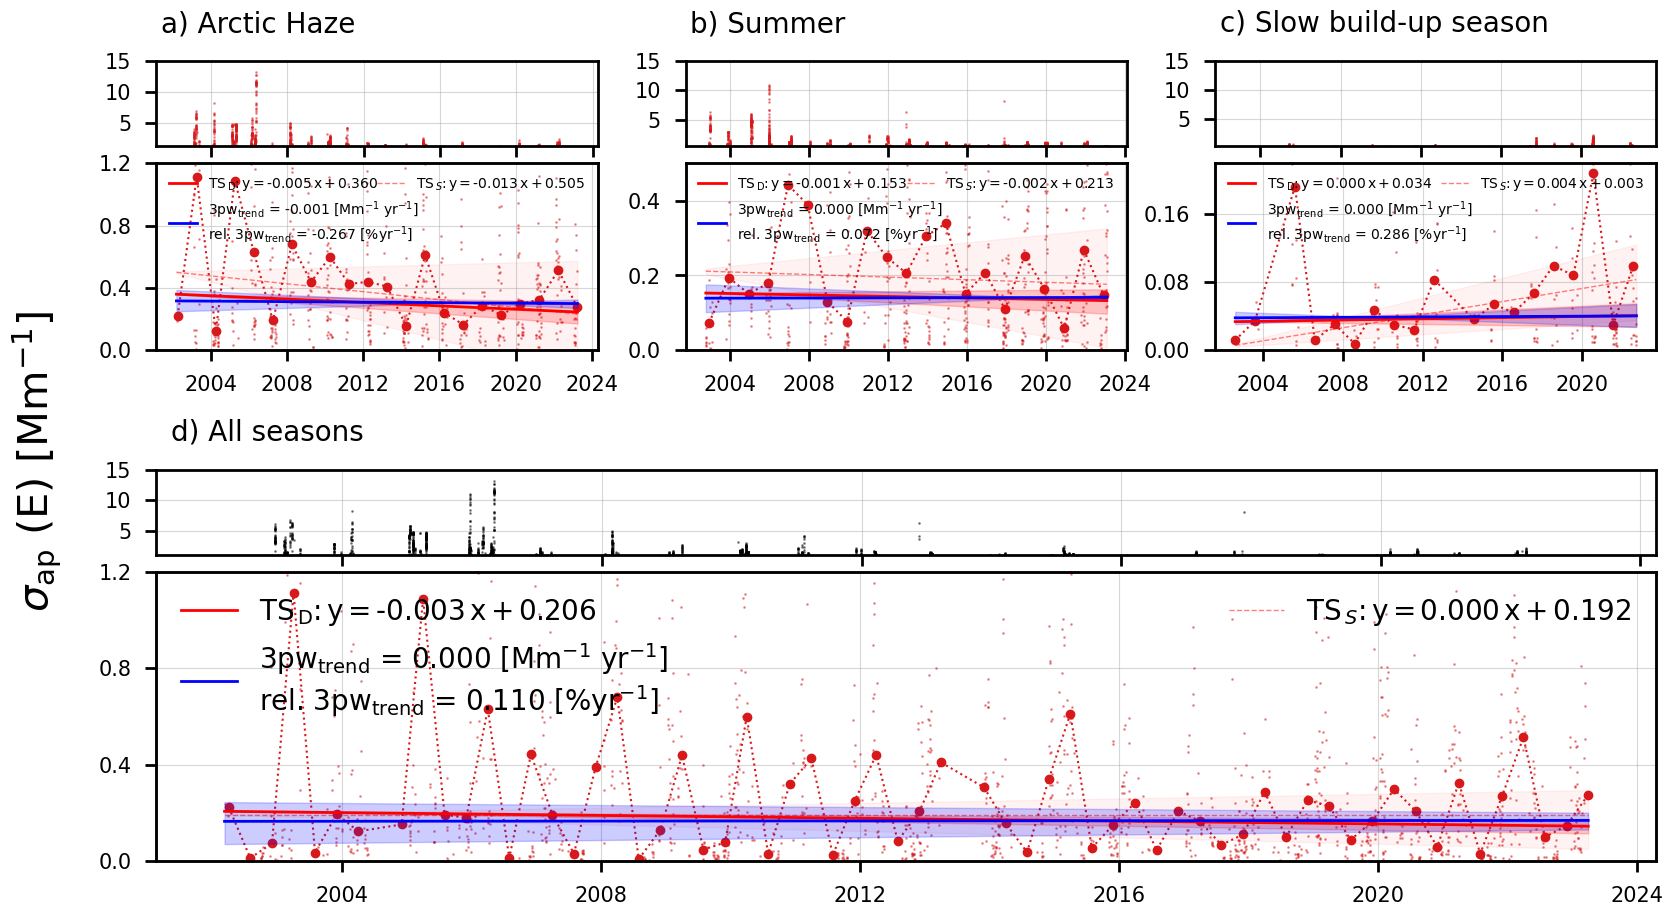

saved as: abs_trend_plot\\default_name.png
saved as: C:\Users\DominicHeslinRees\Documents\ACP_2023\plots\\FigureS13.png


In [31]:
fig = produce_cluster_subplot_trends(df_max_count_abs637, cluster=5, 
                               alpha_xhomo=36, 
                               dict_season_to_ylim={'AHZ': 1.2, 'SBU': 0.5, 'SUM': 0.22, 'all_seasons': 1.2},
                               dict_season_to_color=dict_season_to_color)
fu_trends.save_plot(fig, savepath_plot, name='FigureS13', formate='.png')